In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [8]:
class World:        ### fig:world_init_add_timespan (1-6行目)
    def __init__(self, time_span, time_interval, debug=False): #time_span, time_intervalを追加
        self.objects = []  
        self.debug = debug
        self.time_span = time_span                  # 追加
        self.time_interval = time_interval          # 追加
        
    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)
    
    def draw(self):            ### fig:world_draw_with_timespan (11, 22-36行目)
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5,5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5,5)                              # Y軸も同様に
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に
        
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)  #固定値から変更
        else:
            ### FuncAnimationのframes, intervalを変更 ###
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)    # 時刻として表示する文字列
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)                 # 変更

In [19]:
class IdealRobot:            ### fig:robot_camera（1,2,8,28-29行目,49-53行目）
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        self.pose = pose  
        self.r = 0.2  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor    # 追加
    
    def draw(self, ax, elems):
        x, y, theta = self.pose 
        xn = x + self.r * math.cos(theta) 
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c)) 
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1:                    #追加
            self.sensor.draw(ax, elems, self.poses[-2])     #追加
            
    @classmethod 
    def state_transition(self, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None #追加
        nu, omega = self.agent.decision(obs) #引数追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [4]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega

In [10]:
class Landmark:
    def __init__(self,x,y):
        self.pos = np.array([x,y]).T
        self.id = None

    def draw(self,ax,elems):
        c = ax.scatter(self.pos[0],self.pos[1],s=100,marker="*",label="landmarks",color="orange")

In [11]:
class Map:
    def __init__(self):  
        self.landmarks = []                                     # 空のランドマークのリストを準備
        
    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)          # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                            # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks:
            lm.draw(ax, elems)

In [17]:
class IdealCamera:                      ### fig:camera2（1-4行目、6, 12-13行目, 26-32行目）
    def __init__(self, env_map):
        self.map = env_map
        self.lastdata = []       # 追加
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            observed.append((z, lm.id))
            
        self.lastdata = observed  # 追加
        return observed   
     
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T
    
    def draw(self, ax, elems, cam_pose):    # 追加 ###camera2_1
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")

<IPython.core.display.Javascript object>


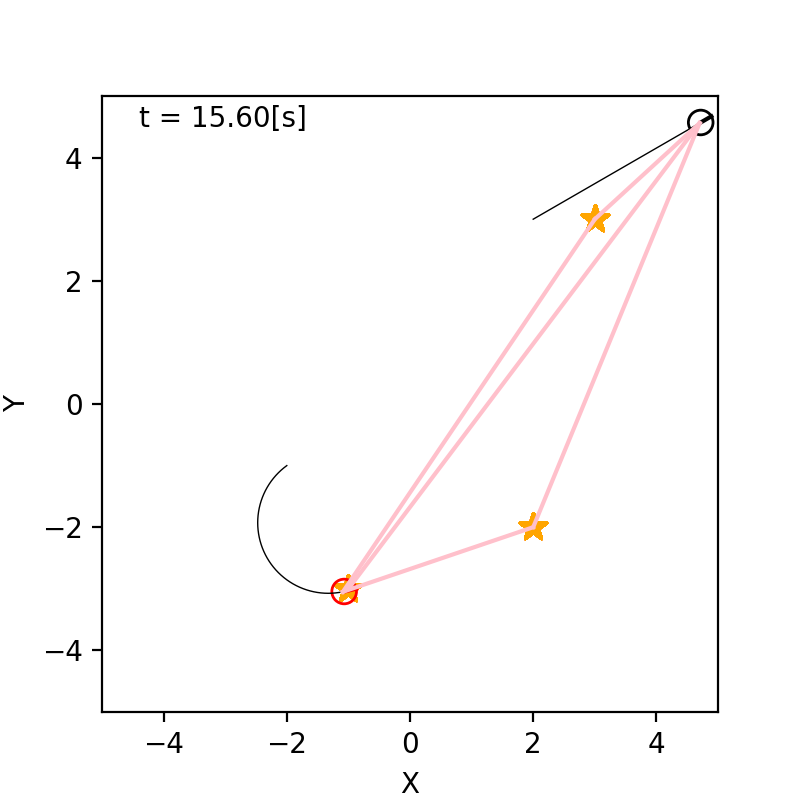

In [21]:
world = World(20, 0.1, debug=False)           ### fig:sensor_drawing (10-19行目)

### 地図を生成して3つランドマークを追加 ###
m = Map()                                  
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-1,-3))
m.append_landmark(Landmark(3,3))
world.append(m)          

### ロボットを作る ###
straight = Agent(0.2, 0.0)    
circling = Agent(0.2, 10.0/180*math.pi)  
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    sensor=IdealCamera(m), agent=straight )             # 引数にcameraを追加、整理
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, sensor=IdealCamera(m), agent=circling, color="red")  # robot3は消しました
world.append(robot1)
world.append(robot2)

### アニメーション実行 ###
world.draw()

In [15]:
cam = IdealCamera(m)                ### fig:try_camera
p =cam.data(robot2.pose)
print(p)

[(array([4.16661716, 0.92102083]), 0), (array([5.88114558, 2.11686245]), 1), (array([7.70283017, 1.5813995 ]), 2)]
